In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import sys
import spikeinterface.full as si
import pandas as pd

os.chdir('/Volumes/violam/home/Master_Thesis_LBB')
sys.path.append('cmos_toolbox_single_neurons-1')

from src.utils.metadata_functions import load_metadata_as_dataframe

/Users/amelieviol/miniconda3/envs/cmos_toolbox_single_neurons/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Chip_ID = 1821
DIVs = [28]
SORTING_OUTPUT_PATH = f"/Volumes/violam/neuronies/single_neurons/3_Student_Projects/Amelie/Processed_data/Chip{Chip_ID}"
RECORDINGS_PATH = f"/Volumes/violam/neuronies/single_neurons/3_Student_Projects/Amelie/Raw_data/Chip{Chip_ID}"
ANALYZER_PATH = f"/Volumes/violam/neuronies/single_neurons/3_Student_Projects/Amelie/Processed_data/Chip{Chip_ID}"

In [3]:
def get_metadata(DIV):
    file_path = os.path.join(RECORDINGS_PATH, f"Chip{Chip_ID}_DIV{DIV}")
    metadata = load_metadata_as_dataframe(file_path)
    return metadata

In [4]:
def load_extremum_unit_data(DIV):    
    processed_extremum = f"Chip{Chip_ID}_DIV{DIV}/Analyzer/processed_data_extremum.pkl"
    file_path = os.path.join(ANALYZER_PATH, processed_extremum)

    # Display the contents of the pickle file
    with open(file_path, 'rb') as file:
        Extremum_unit_data = pickle.load(file)

    return Extremum_unit_data

In [5]:
all_waveforms = []
mean_waveforms = []

for i in range(len(DIVs)):
    print(i) 
    mean_amplitudes = []
    metadata = get_metadata(DIV=DIVs[i])
    for idx, filename in enumerate(metadata.Filename):
        print(idx)
        input_name = (f"Chip{Chip_ID}_DIV{DIVs[i]}/{filename[:-3]}_processed.pkl")

        if not os.path.isfile(os.path.join(SORTING_OUTPUT_PATH, input_name)):
            print(os.path.join(SORTING_OUTPUT_PATH, filename))
            print(f"Pickle file for {input_name} does not exist. Skipping this network.")
            continue  # Skip to the next iteration
    
        filename = (f"Sorter_{filename}")
        analyzer_path = os.path.join(SORTING_OUTPUT_PATH, f"Chip{Chip_ID}_DIV{DIVs[i]}/{filename}/analyzer_curated")
        analyzer = si.load_sorting_analyzer(os.path.join(analyzer_path))
        unit_ids = analyzer.unit_ids
        waveform_extension = analyzer.get_extension("waveforms")

        for unit_id in unit_ids:
            waveforms_per_unit = waveform_extension.get_waveforms_one_unit(unit_id = unit_id)

            # waveforms shape: (num_spikes, num_time_samples, num_channels_per_unit)
            mean_waveform = np.mean(waveforms_per_unit, axis=(0)) # Average over spikes
            
            '''
            # Compute peak-to-peak amplitude for each channel
            peak_to_peak = np.max(mean_waveform, axis=0) - np.min(mean_waveform, axis=0)

            # Find the channel with the highest amplitude
            best_channel_idx = np.argmax(peak_to_peak)
            '''

            # Find the **most negative** peak per channel
            min_values = np.min(mean_waveform, axis=0)  # Minimum value for each channel
            
            # Find the channel with the **lowest minimum value (most negative)**
            best_channel_idx = np.argmin(min_values) 

            # Extract the waveform from the best channel
            best_waveform = mean_waveform[:, best_channel_idx]  # Shape: (num_time_samples,)

            # Find peak index (where the absolute max value occurs)
            peak_idx = np.argmax(np.abs(best_waveform))

            nw_id = metadata["Network_ID"].iloc[idx]

            # Store in list
            all_waveforms.append({
                'DIV': DIVs[i],                # DIV identifier
                'UnitID': unit_id,             # Unit identifier
                'Best_Channel': best_channel_idx,  # Index of the highest amplitude channel
                'Best_Waveform': best_waveform,     # Best waveform (1D)
                'NW_ID': nw_id
            })

            mean_waveforms.append({
                'DIV': DIVs[i],                # DIV identifier
                'UnitID': unit_id,             # Unit identifier
                'NW_ID': nw_id,
                'Mean_waveform': mean_waveform,  # mean waveforms per channel
            })

# Convert the list of dictionaries to a DataFrame
df_waveforms = pd.DataFrame(all_waveforms)        
df_waveforms


2025-02-05 11:01:51,236 The file '/Volumes/violam/neuronies/single_neurons/3_Student_Projects/Amelie/Raw_data/Chip1821/Chip1821_DIV28' does not exist. Creating metadata now...
2025-02-05 11:01:51,377 Metadata successfully created and saved. 
 First 5 rows: 
                                             Filename DIV_NGN2 Chip_ID  \
0  ID1821_N6_DIV28_DATE20241213_1401_spontaneous_...       28    1821   
1  ID1821_N7_DIV28_DATE20241213_1401_spontaneous_...       28    1821   
2  ID1821_N0_DIV28_DATE20241213_1401_spontaneous_...       28    1821   
3  ID1821_N3_DIV28_DATE20241213_1401_spontaneous_...       28    1821   
4  ID1821_N2_DIV28_DATE20241213_1401_spontaneous_...       28    1821   

  Network_ID  
0          6  
1          7  
2          0  
3          3  
4          2  


0
0
1
2
3
4
5
6
7


,DIV,UnitID,Best_Channel,Best_Waveform,NW_ID
0,28,2,17,"[-13.702382, -6.115287, 0.06198074, -0.4861025...",6
1,28,12,5,"[20.93351, 30.658285, 40.557114, 49.901115, 58...",6
2,28,35,15,"[82.81309, 83.4286, 79.5165, 69.43247, 51.3742...",6
3,28,38,1,"[-40.06022, -42.617577, -45.844357, -50.130325...",6
4,28,52,22,"[-13.926739, -10.98211, -8.188208, -5.7341795,...",6
...,...,...,...,...,...
2057,28,1093,21,"[106.1574, 102.36221, 94.509926, 85.6129, 76.0...",5
2058,28,1094,17,"[32.364384, 33.173244, 35.29928, 38.67826, 40....",5
2059,28,1096,24,"[11.7811165, 12.952378, 13.87894, 14.823987, 1...",5
2060,28,1097,19,"[317.55795, 316.5293, 254.87903, 134.18309, -9...",5


[-55.934086   -12.5539     -70.03894    -62.447834    -9.31903
 -34.620564    -0.08752156  -3.435118    -0.46041712 -12.347969
  -1.9491313   -6.0997486  -12.6811285  -72.754715   -14.150584
 -11.720351    -8.5722685  -56.79746    -12.729959    -7.688787
 -27.810658    -4.372508    -3.5042365  -13.6633625  -10.676696  ]


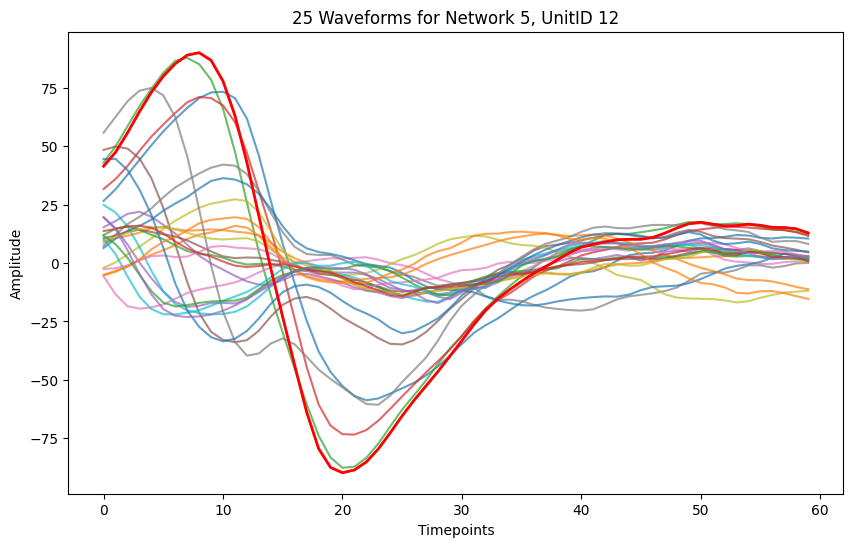

In [16]:
df_mean_waveforms = pd.DataFrame(mean_waveforms)        
df_mean_waveforms

target_NW = 5
target_UnitID = 12

# Select a specific row based on DIV and UnitID (change values as needed)
selected_row = df_mean_waveforms[(df_mean_waveforms['NW_ID'] == target_NW) & (df_mean_waveforms['UnitID'] == target_UnitID)]

# Extract the mean waveforms from the row
if not selected_row.empty:
    waveforms = np.array(selected_row['Mean_waveform'].values[0])  # Extract waveforms from the first match
    print(waveforms[i])

    # Normalize each waveform individually
    waveforms_normalized = np.zeros_like(waveforms)  # Placeholder for results

    for i in range(waveforms.shape[1]):  # Loop over all 25 waveforms (columns)
        min_val = waveforms[:, i].min()  # Min of each waveform
        max_val = waveforms[:, i].max()  # Max of each waveform

        if max_val != min_val:  # Avoid division by zero
            waveforms_normalized[:, i] = (waveforms[:, i] - min_val) / (max_val - min_val)
        else:
            waveforms_normalized[:, i] = 0  # If all values are the same, set to 0

    # Extract the extremum waveform from df_waveforms
    selected_extremum = df_waveforms[(df_waveforms['NW_ID'] == target_NW) & (df_waveforms['UnitID'] == target_UnitID)]

    if not selected_extremum.empty:
        extremum_waveform = np.array(selected_extremum['Best_Waveform'].values[0])  # Shape: (60,)
    else:
        extremum_waveform = None  # No extremum waveform found

    # Plot all 25 waveforms
    plt.figure(figsize=(10, 6))
    timepoints = np.arange(60)  # Create x-axis (0 to 59)

    for i in range(25):  # Loop through all 25 waveforms
        plt.plot(timepoints, waveforms[:, i], alpha=0.7, label=f"Waveform {i+1}")
    
    # Plot extremum waveform in red with a thicker line
    if extremum_waveform is not None:
        plt.plot(timepoints, extremum_waveform, color='red', linewidth=2, label="Extremum Waveform")


    plt.xlabel("Timepoints")
    plt.ylabel("Amplitude")
    plt.title(f"25 Waveforms for Network {target_NW}, UnitID {target_UnitID}")
    plt.show()
else:
    print("No matching row found!")




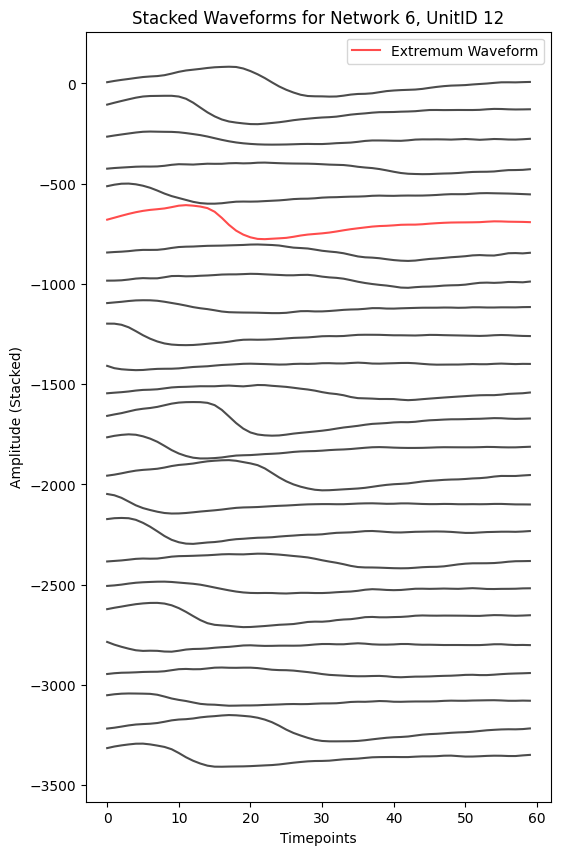

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_mean_waveforms = pd.DataFrame(mean_waveforms)

target_NW = 6
target_UnitID = 12

# Select the specific row based on NW_ID and UnitID
selected_row = df_mean_waveforms[(df_mean_waveforms['NW_ID'] == target_NW) & (df_mean_waveforms['UnitID'] == target_UnitID)]

# Extract the mean waveforms from the row
if not selected_row.empty:
    waveforms = np.array(selected_row['Mean_waveform'].values[0])  # Shape: (60, 25)

    # Extract the extremum waveform index from df_waveforms
    selected_extremum = df_waveforms[(df_waveforms['NW_ID'] == target_NW) & (df_waveforms['UnitID'] == target_UnitID)]
    
    extremum_index = None
    if not selected_extremum.empty:
        extremum_waveform = np.array(selected_extremum['Best_Waveform'].values[0])  # Shape: (60,)
        # Find the index of the extremum waveform in the 25 waveforms
        extremum_index = np.argmin(np.min(waveforms, axis=0))  # Channel with most negative peak

    # Plot all 25 waveforms stacked below each other
    plt.figure(figsize=(6, 10))
    timepoints = np.arange(60)  
    spacing = 1.5 * np.max(np.abs(waveforms))  # Set spacing based on waveform amplitude

    for i in range(25):  
        color = 'red' if i == extremum_index else 'black'  # Extremum waveform in red
        plt.plot(timepoints, waveforms[:, i] - i * spacing, alpha=0.7, color=color, label="Extremum Waveform" if i == extremum_index else None)
    
    # Formatting
    plt.xlabel("Timepoints")
    plt.ylabel("Amplitude (Stacked)")
    plt.title(f"Stacked Waveforms for Network {target_NW}, UnitID {target_UnitID}")
    plt.legend()
    plt.show()

else:
    print("No matching row found!")


In [7]:
df_waveforms['Type'] = 0
df_waveforms

,DIV,UnitID,Best_Channel,Best_Waveform,NW_ID,Type
0,28,2,17,"[-13.702382, -6.115287, 0.06198074, -0.4861025...",6,0
1,28,12,5,"[20.93351, 30.658285, 40.557114, 49.901115, 58...",6,0
2,28,35,15,"[82.81309, 83.4286, 79.5165, 69.43247, 51.3742...",6,0
3,28,38,1,"[-40.06022, -42.617577, -45.844357, -50.130325...",6,0
4,28,52,23,"[-15.402832, -12.993165, -9.217203, -4.9229774...",6,0
...,...,...,...,...,...,...
2057,28,1093,21,"[106.1574, 102.36221, 94.509926, 85.6129, 76.0...",5,0
2058,28,1094,17,"[32.364384, 33.173244, 35.29928, 38.67826, 40....",5,0
2059,28,1096,12,"[70.48635, 75.16051, 78.04033, 78.38729, 74.15...",5,0
2060,28,1097,0,"[312.51898, 336.5763, 327.4154, 264.04803, 144...",5,0


In [19]:
df = df_waveforms[['Best_Waveform']].copy()
array = df.to_numpy()
array[0][0]

array([-1.37023821e+01, -6.11528683e+00,  6.19807392e-02, -4.86102521e-01,
       -3.05091429e+00, -9.80231643e-01,  5.03989124e+00,  1.08138914e+01,
        1.49619341e+01,  1.78990936e+01,  2.06774216e+01,  2.64358902e+01,
        3.59240227e+01,  4.56981773e+01,  5.44399033e+01,  6.71107330e+01,
        8.32195511e+01,  9.79616241e+01,  1.12108879e+02,  1.28118774e+02,
        1.43566605e+02,  1.54706314e+02,  1.59400757e+02,  1.50751572e+02,
        1.25690331e+02,  9.55548172e+01,  7.32675781e+01,  5.59453773e+01,
        3.72861252e+01,  1.94275513e+01, -5.78172088e-01, -3.19226017e+01,
       -7.01937714e+01, -1.00697693e+02, -1.17054375e+02, -1.24200272e+02,
       -1.27431458e+02, -1.27757492e+02, -1.25181595e+02, -1.17890030e+02,
       -1.04436852e+02, -8.71545715e+01, -7.10045395e+01, -5.93317909e+01,
       -5.11198349e+01, -4.46564789e+01, -4.01420898e+01, -3.69315071e+01,
       -3.22905922e+01, -2.74892044e+01, -2.37175446e+01, -1.90733662e+01,
       -1.44417362e+01, -

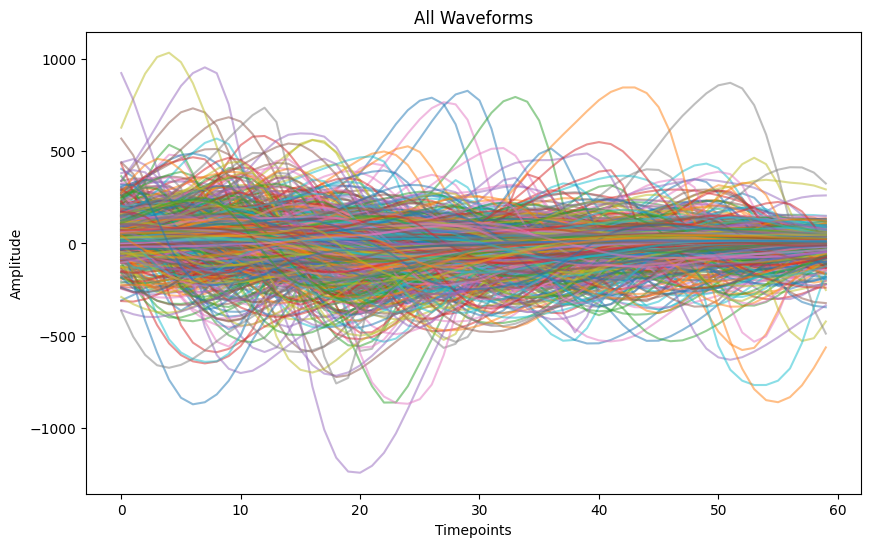

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the array to a NumPy array for easy manipulation
waveforms = np.array([waveform[0] for waveform in array])  # Extract the actual waveform values

# Plot all waveforms
plt.figure(figsize=(10, 6))
for i in range(len(waveforms)):
    
    waveforms_normalized = np.zeros_like(waveforms)  # Placeholder for results
    #print(waveforms_normalized.shape)

    min_val = waveforms[i].min()  # Min of each waveform
    max_val = waveforms[i].max()  # Max of each waveform

    if max_val != min_val:  # Avoid division by zero
        waveforms_normalized[i] = (waveforms[i] - min_val) / (max_val - min_val)
    else:
        waveforms_normalized[i] = 0  # If all values are the same, set to 0


    plt.plot(waveforms[i], alpha=0.5)  # Use alpha for transparency to see overlapping waveforms

plt.xlabel("Timepoints")
plt.ylabel("Amplitude")
plt.title("All Waveforms")
plt.show()


In [37]:
OUTPUT_PATH = f"/Volumes/violam/neuronies/single_neurons/3_Student_Projects/Amelie/Datasets/Waveforms/Chip{Chip_ID}/Chip{Chip_ID}_waveforms.pkl"

# Save the DataFrame with pickle
with open(OUTPUT_PATH, 'wb') as f:
    pickle.dump(df_waveforms, f)

print(f"DataFrames successfully saved.")

DataFrames successfully saved.


## Merge data

In [31]:
OUTPUT_PATH_ngn2_1 = f"/Volumes/violam/neuronies/single_neurons/3_Student_Projects/Amelie/Datasets/Waveforms/Chip1908/Chip1908_waveforms.pkl"
OUTPUT_PATH_ngn2_2 = f"/Volumes/violam/neuronies/single_neurons/3_Student_Projects/Amelie/Datasets/Waveforms/Chip1765/Chip1765_waveforms.pkl"
OUTPUT_PATH_gaba_1 = f"/Volumes/violam/neuronies/single_neurons/3_Student_Projects/Amelie/Datasets/Waveforms/Chip2034/Chip2034_waveforms.pkl"
#OUTPUT_PATH_gaba_2 = f"/Volumes/violam/neuronies/single_neurons/3_Student_Projects/Amelie/Datasets/Waveforms/Chip{Chip_ID}/Chip{Chip_ID}_waveforms.pkl"

Waveform_dataset = f"/Volumes/violam/neuronies/single_neurons/3_Student_Projects/Amelie/Datasets/Waveforms/1908_1765_2034_waveforms.pkl"

DIVs = [27, 28, 35, 42, 49]

# Load the DataFrame with pickle
with open(OUTPUT_PATH_ngn2_1, 'rb') as f:
    df_ngn2_1 = pickle.load(f)
df_ngn2_1_divs = df_ngn2_1[df_ngn2_1['DIV'].isin(DIVs)]
with open(OUTPUT_PATH_ngn2_2, 'rb') as f:
    df_ngn2_2 = pickle.load(f)
df_ngn2_2_divs = df_ngn2_2[df_ngn2_2['DIV'].isin(DIVs)]
with open(OUTPUT_PATH_gaba_1, 'rb') as f:
    df_gaba_1 = pickle.load(f)
df_gaba_1_divs = df_gaba_1[df_gaba_1['DIV'].isin(DIVs)]

df_all = pd.concat([df_ngn2_1_divs, df_ngn2_2_divs, df_gaba_1_divs], ignore_index=True)
df_all

# Save the DataFrame with pickle
with open(Waveform_dataset, 'wb') as f:
    pickle.dump(df_all, f)

print(f"DataFrames successfully saved.")


DataFrames successfully saved.


In [11]:
# Select a unit to visualize
unit_id_to_plot = 53
nw_id_to_plot = 3

# Extract the waveform for this unit
unit_data = df_waveforms[(df_waveforms["UnitID"] == unit_id_to_plot) & 
                         (df_waveforms["NW_ID"] == nw_id_to_plot)]

if unit_data.empty:
    print(f"No data found for Unit {unit_id_to_plot}.")
else:
    best_waveform = unit_data["Best_Waveform"].values[0]  # Shape: (num_time_samples,)
    best_channel = unit_data["Best_Channel"].values[0]

    # Define time axis
    time_samples = np.arange(len(best_waveform))/20

    # Plot the waveform
    plt.figure(figsize=(8, 4))
    plt.plot(time_samples, best_waveform, label=f"Unit {unit_id_to_plot}, Best Channel {best_channel}")
    plt.title(f"Waveform from Best Channel ({best_channel}) for Unit {unit_id_to_plot}")
    plt.xlabel("Time [ms]")
    plt.ylabel("Amplitude [uV]")
    plt.legend()
    plt.grid()
    plt.show()


No data found for Unit 53.


In [1]:
# Select a unit to visualize (change UnitID as needed)
unit_id_to_plot = 509  # Change this to the desired UnitID

# Extract the waveform data for this unit
unit_data = next((d for d in mean_waveforms if d["UnitID"] == unit_id_to_plot), None)

if unit_data is None:
    print(f"No data found for Unit {unit_id_to_plot}.")
else:
    mean_waveform = unit_data["Mean_waveform"]  # Shape: (num_time_samples, num_channels)
    
    # Define time axis
    time_samples = np.arange(mean_waveform.shape[0])

    # Plot all 25 channels
    plt.figure(figsize=(10, 6))
    for ch in range(mean_waveform.shape[1]):  # Loop through channels
        plt.plot(time_samples, mean_waveform[:, ch], label=f"Ch {ch}")

    plt.title(f"Waveforms for All 25 Channels - Unit {unit_id_to_plot}")
    plt.xlabel("Time Samples")
    plt.ylabel("Amplitude")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0), fontsize="small")
    plt.grid()
    plt.show()


NameError: name 'mean_waveforms' is not defined